In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random
using Test
using MeshCat
using MeshCatMechanisms
using RigidBodyDynamics
using StaticArrays
using CoordinateTransformations
using Rotations

WebIO._IJuliaInit()

In [3]:
include("src/cost.jl")
include("src/linearize_dynamics.jl")
include("src/lqgame.jl")
include("src/solveilqgame.jl")
include("src/dynamics.jl");
# include("src/diff_robot.jl");

### Quadcopter Nonlinear Dynamics

The states and inputs for the nonlinear quadcopter dynamics are defined as:

$$
\begin{equation}
x = [x, y, z, \dot{x}, \dot{y}, \dot{z}, \phi, \theta, \Psi]^{T} \\
\end{equation}
$$

$$
\begin{equation}
u = [\dot{z}_{cmd}, \phi_{cmd}, \theta_{cmd}, \dot{\Psi}_{cmd}]^{T}
\end{equation}
$$

And the nonlinear system model is defined by:

$$
\begin{equation}
\dot{x} = f(x(t), u(t)) = \begin{bmatrix}
           \dot{x} \\
           \dot{y} \\
           \dot{z} \\
           \ddot{x} \\
           \ddot{y} \\
           \ddot{z} \\
           \dot{\phi} \\
           \dot{\theta} \\
           \dot{\Psi} \\
         \end{bmatrix} = \begin{bmatrix}
           \dot{x} \\
           \dot{y} \\
           \dot{z} \\
           \frac{sin(\phi)sin(\Psi)+cos(\phi)sin(\theta)cos(\Psi)(\ddot{z}+g)}{cos(\theta)cos(\phi)} \\
           \frac{-sin(\phi)sin(\Psi)+cos(\phi)sin(\theta)sin(\Psi)(\ddot{z}+g)}{cos(\theta)cos(\phi)} \\
           \frac{1}{\tau_{z}} (\dot{z}_{cmd} - \dot{z}) \\
           \frac{1}{\tau_{\phi}} (\phi_{cmd} - \phi) \\
           \frac{1}{\tau{}_{\theta}} (\theta_{cmd} - \theta) \\
           \dot{\Psi}_{cmd} \\
         \end{bmatrix}
\end{equation}
$$


In [4]:
# Setup the problem
dt = 0.1                    # Step size [s]
H = 10.0                    # Horizon [s]
k_steps = Int(H/dt)         # Number of steps (knot points)

# Initial and final states
# x₁, y₁, θ₁     

x₀= [10.0; 10.0; 5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; -10.0; -10.0; 5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]        # Initial state
xgoal = [-10.0; -10.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 10.0; 10.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0];  # Final state

In [5]:
# Define cost matrices 

Q1 = sparse(zeros(18,18))     # State cost for agent 1
Q1[1:9,1:9] = 3.0*I(9)
Qn1 = Q1                    # Terminal cost for agent 1

Q2 = sparse(zeros(18,18))     # State cost for agent 2
Q2[10:18,10:18] = 9.0*I(9)
Qn2 = Q2                    # Terminal cost for agent 2

R11 = 1.0*I(4)              # Control cost for player 1
R22 = 1.0*I(4)              # Contorl cost for player 2
R12 = sparse(zeros(4,4))    # Control cost for player 1 associated with player 2's controls
R21 = sparse(zeros(4,4))    # Control cost for player 2 associated with player 1's controls

dmax = 2.0                  # Distance that both agents should keep between each other [m]
ρ = 500.0                   # Penalty factor for violating the distance constraint

# Input constraints
umax = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]            
umin = [-10.0,-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]

u1goal = [0.0, 0.0, 0.0, 0.0]
u2goal = [0.0, 0.0, 0.0, 0.0];

In [6]:
xₜ, uₜ = solveILQGame(quadcopter, costQuadcopter, x₀, xgoal, u1goal, u2goal, Q1, Q2, Qn1, Qn2, R11, R12, R21, R22, umin, umax, dmax, ρ, dt, H)

([10.0 10.0 … 0.0 0.0; 9.997102519013914 9.999250708893028 … -0.7656552955938286 -1.0; … ; -9.977234094971205 -9.99865758356618 … -0.05140827790784507 0.001460562921858804; -9.81916490259425 -9.99790220231576 … -0.04284649706940424 0.0013399659825469746], [-8.533747599228434 -0.03163216526071588 … -8.04576693123687 -10.0; -1.7394493227513759 -0.0641450428531038 … -9.153818951580691 -10.0; … ; -0.4482317083539193 0.00020152111757922497 … 0.03856183467264449 -0.0012059693931182932; 0.0 0.0 … 0.0 0.0])

In [7]:
xₜ[end,:]

18-element Vector{Float64}:
 -9.81916490259425
 -9.99790220231576
 -0.07431638122000506
 -0.2827760499971612
 -4.849110308442067e-5
 -0.4242513678993419
 -0.0006717969774144298
 -1.2531177442558046
  0.004035281881776227
  9.982652816856113
 10.002760876754923
 -0.09946571295028597
  0.055275566562573174
 -0.0031600187828045
 -0.03225478002260647
 -7.496608451455165e-5
 -0.04284649706940424
  0.0013399659825469746

┌ Info: Saved animation to /home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/assets/quadcopter.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/assets/quadcopter.gif")
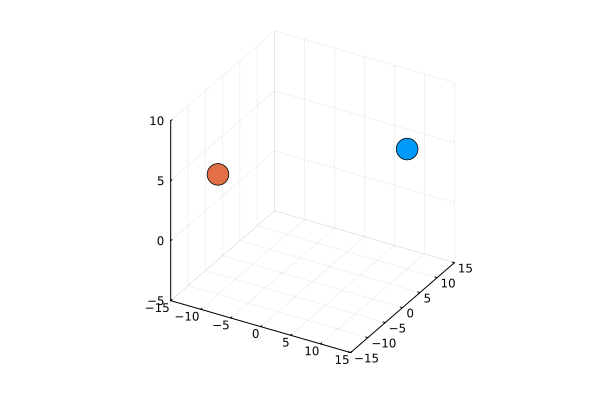

In [8]:
anim = @animate for t in 1:k_steps
    scatter3d([xₜ[t, :][1]], [xₜ[t, :][2]], [xₜ[t, :][3]], m = (:circle, 12),
    xlims = (-15, 15), 
    ylims = (-15, 15), 
    zlims = (-5, 10),
    legend = false)
    scatter3d!([xₜ[t, :][10]], [xₜ[t, :][11]], [xₜ[t, :][12]], m = (:circle, 12))
    # plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :black))
    # plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
end every 1;
gif(anim, "assets/quadcopter.gif")

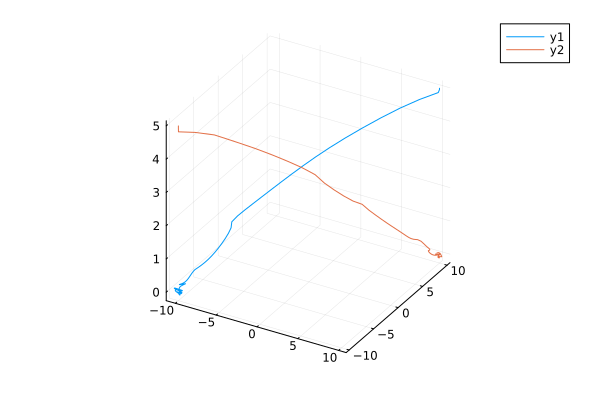

In [11]:
plot3d(xₜ[:, 1], xₜ[:, 2], xₜ[:, 3])
plot3d!(xₜ[:, 10], xₜ[:, 11], xₜ[:, 12])

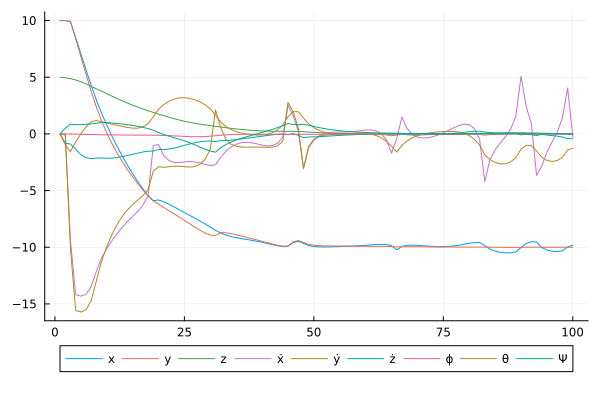

In [24]:
# Plot of all states for agent 1

plot(xₜ[:, 1:9], 
    label=["x" "y" "z" "ẋ" "ẏ" "ż" "ϕ" "θ" "Ψ"],
    legend=:outerbottom, 
    legendcolumns=9)

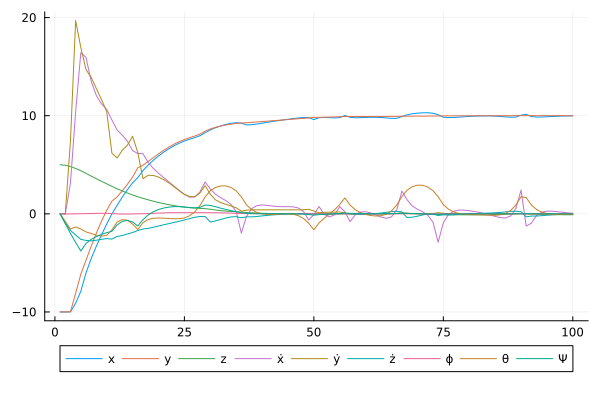

In [26]:
# Plot of all states for agent 2

plot(xₜ[:, 10:18], 
    label=["x" "y" "z" "ẋ" "ẏ" "ż" "ϕ" "θ" "Ψ"],
    legend=:outerbottom, 
    legendcolumns=9)